# Gender in the Library of Congress Subject Headings

### Imports

In [1]:
import pickle as pk
import random
import matplotlib.pyplot as plt 
import numpy as np
import re
import csv
import collections

### Functions

In [67]:
def getDep(lcsh):
    count = 0
    dep = {}
    for idx, heading in lcsh.items():
        if heading['yearDep'] is not None:
            dep[idx] = heading
            count += 1
    return count, dep

def getNew(term):
    return int(term['yearNew'][:4])

def percent(num, denom):
    return num/denom*100

def countTypes(lcsh):
    kinds = {}
    for heading in lcsh.values():
        kind = heading['type']
        if kind in kinds:
            kinds[kind] += 1
        else:
            kinds[kind] = 1
    return kinds

def getSimple(lcsh):
    simple = {}
    simpleTypes = ['Topic', 'Geographic', 'CorporateName', 'FamilyName', 'Title', 
                   'ConferenceName', 'PersonalName']
    for idx, term in lcsh.items():
        if term['type'] in simpleTypes:
            simple[idx] = term
    return simple

def getCatBreakdown(lcsh, raw=False):
    total = len(lcsh)
    cats = {}
    for term in lcsh.values():
        cat = term['lcc'][0]
        if raw:
            val = 1
        else:
            val = 1/total
        if cat in cats:
            cats[cat] += val
        else:
            cats[cat] = val
    return cats

def pruneDeprecated(lcsh):
    pruned = {}
    for idx, term in lcsh.items():
        if term['yearDep'] is None:
            pruned[idx] = term
        else:
            if int(term['yearDep'][:4]) -int(term['yearNew'][:4]) >= 1:
                pruned[idx] = term
    return pruned

def getLCCTerms(lcsh):
    lccTerms = {}
    for idx, term in lcsh.items():
        if term['lcc'] is not None:
            lccTerms[idx] = term
    return lccTerms

def compareLCC(wCats, mCats, label, raw=False):
    catSpan = sorted(list(set(list(mCats.keys()) + list(wCats.keys()))))
    for cat in catSpan:
        if cat not in wCats.keys():
            wCats[cat] = 0
        if cat not in mCats.keys():
            mCats[cat] = 0
    wCats = {cat: count for cat, count in sorted(wCats.items(), key = lambda x: x[0])}
    mCats = {cat: count for cat, count in sorted(mCats.items(), key = lambda x: x[0])}
    width = 0.4

    _, ax = plt.subplots(figsize = (10, 5))
    ax.spines[['top', 'right']].set_visible(False)
    x = np.array([i for i in range(len(catSpan))])
    plt.bar(x-width, wCats.values(), width, align='edge', color='rebeccapurple', edgecolor='black', label='Men')
    plt.bar(x, mCats.values(), width, align='edge', color='goldenrod', edgecolor='black', label='Women')
    plt.xticks(x, catSpan)
    plt.legend(frameon=False, loc='upper left')
    plt.title(f'LCC Category Distirbution of {label} for Men and Women')
    plt.xlabel('Category')
    if raw:
        plt.ylabel('Number of Terms')
    else:
        plt.ylabel('Proportion of Terms')
    plt.show()
    
def getTimeLine(lcsh):
    years = [y for y in range(1986, 2024)]
    timeline = {y:0 for y in years}
    for term in lcsh.values():
        yearAdded = getNew(term)
        if yearAdded != 2024:
            timeline[yearAdded] += 1
        if term['yearDep'] is not None:
            yearDep = int(term['yearDep'][:4])
            if yearDep != 2024:
                timeline[yearDep] -= 1
    return timeline
    
def plotStacked(x, yDict, colours, title, xLabel, yLabel):
    width = 0.8
    _, ax = plt.subplots(figsize = (15, 5))
    bottom = np.zeros(len(x))
    i = 0
    for lab, counts in yDict.items():
        p = ax.bar(x, counts, width, label=lab, bottom=bottom, color=colours[i])
        bottom += counts
        i += 1
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(x, rotation=90)
    plt.show()
    
def getData(fileName):
    freqs, heads, yrs, indices = [], [], [], []
    with open(fileName, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            indices.append(row[0])
            heads.append(row[1])
            yrs.append(int(row[2]))
            freqs.append(np.array(row[3:], dtype=float))
    return np.row_stack(freqs), yrs, heads, indices

def findPairs(mTerms, wTerms, pairs):
    pairedTerms = []
    indicesW, indicesM = [], []
    mHeads = [t['heading'] for t in mTerms.values()]
    wHeads = [t['heading'] for t in wTerms.values()]
    for i in range(len(pairs)):
        wordM, wordW = pairs[i]
        replaced = {}
        for i, head in enumerate(wHeads):
            wHead = head.lower()
            if wordW in wHead:
                replaced[wHead.replace(wordW, '')] = i
        for i, head in enumerate(mHeads):
            mHead = head.lower()
            if wordM in mHead:
                genTerm = mHead.replace(wordM, '')
                if genTerm in replaced.keys() and i not in indicesM and replaced[genTerm] not in indicesW:
                    pairedTerms.append((list(mTerms.items())[i],list(wTerms.items())[replaced[genTerm]]))
                    indicesM.append(i)
                    indicesW.append(replaced[genTerm])
    return pairedTerms

def processGenderWords(fp):
    genWords = []
    with open(fp, 'r') as f:
        for line in f:
            term = line.replace('\n', '')
            genWords.append(term)
    return genWords

def clean(word):
    return word.lower().replace('(', '').replace(')', '').replace("'", " '").replace(',', '').replace('_', '').replace('-', ' ')

def getGenderedTerms(lcsh, genderWords):
    headings = {}
    for idx, term in lcsh.items():
        flag = False
        if (term['type'] == 'Topic' and term['lang'] == 'en' 
            and '(Fictitious character' not in term['heading']
            and '(Symbolic character' not in term['heading']
            and '(Legendary character' not in term['heading']
            and '(Game)' not in term['heading']
            and '(International relations)' not in term['heading']
            and 'word)' not in term['heading']
            and '(Legend)' not in term['heading']
            and '(Miracle)' not in term['heading']
            and '(Race horse)' not in term['heading']
            and '(Horse)' not in term['heading']
            and '(Dog)' not in term['heading']
            and ' mythology)' not in term['heading']
            and 'deities)' not in term['heading']
            and '(Parable)' not in term['heading']
            and '(Tale)' not in term['heading']
            and '(Nickname)' not in term['heading']
            and '(Statue)' not in term['heading']
            and 'deity)' not in term['heading']
            and '(Art)' not in term['heading']
            and 'locomotives)' not in term['heading']):
            head = clean(term['heading'])
            words = [w for w in head.split(' ')]
            for w in genderWords:
                if w in words:
                    term['genTerm'] = w
                    term['baseForm'] = head
                    flag = True
                    break
        # it seems that in the LCSH that 'gay people' is the more general term with 'gay men' and 'lesbians' being the specific
        # gendered subsets. The following if case makes sure that my method doesn't pick up terms that refer to both lesbians and gay people.
        if 'lesbian' in words and 'gay' in words:
            continue
        if flag:
            # this occasionally comes up because LCSH tends to differentiate by gender using 'gay men' and 'lesbians' but not always
            headings[idx] = term
    return headings

def getAmbig(mTerms, wTerms):
    inBoth = []
    mWords = [term['baseForm'] for term in mTerms.values()]
    mIndex = [idx for idx in mTerms.keys()]
    for wIdx, term in wTerms.items():
        if term['baseForm'] in mWords:
            mIdx = mIndex[mWords.index(term['baseForm'])]
            pair = (mIdx, wIdx)
            inBoth.append(pair)
    return inBoth

def getNgrams(terms, n, genTerm=False):
    nGrams = []
    indices = []
    yrs = []
    for idx, term in terms.items():
        head = term['heading']
        if 'Cooking (' in head and head[:7] == 'Cooking':
            head = head.replace('(', '').replace(')', '')
        elif '(' in head and head.index(')') == len(head)-1 and 'law)' not in head:
            head = re.sub(r'\(.*?\)', r'', head)
        elif 'law)' in head:
            head = re.sub(r'\((.*?)\)', r'in \1', head)
        elif '(' in head and head.index(')') != len(head)-1:
            continue
        head = head.replace('-', ' ').replace("'", " '")
        if genTerm and term['genTerm'] not in head.lower():
            continue
        else:
            if len(head.split(' ')) <= n:
                if head.count(',') == 1:
                    parts = head.split(',')
                    part1 = parts[0].strip()
                    part2 = parts[1].strip()
                    head = part2 + ' ' + part1
                elif head.count(',') > 1:
                    head = re.sub(r"(\w+(( | ')\w+)*), ((\w+)( \w+)*)", r'\4 \1', head).replace(',', '')
                nGrams.append(head.lower().strip())
                yrs.append(getNew(term))
                indices.append(idx)
    return nGrams, yrs, indices

def getAvgProp(freqs, years, yrsBefore, yrsAfter):
    total = yrsBefore + yrsAfter + 1
    lines = np.zeros((len(years), total))
    for i in range (len(years)):
        added = years[i]-1970
        windowMat = freqs[i,added-(yrsBefore+1):added+yrsAfter]
        if np.sum(windowMat) == 0:
            print(f'No N-gram frequency for window at index {i}')
            continue
        lines[i] = windowMat / np.sum(windowMat)
    avgLine = np.mean(lines, axis=0)
    stdLine = np.std(lines, axis=0)
    return avgLine, stdLine

def getControl(freqs, yrsBefore, yrsAfter):
    randomLines = [] 
    for i in range(11, 48):
        windowMat = freqs[:,i-(yrsBefore+1):i+yrsAfter]
        # any non-zero lines - maybe should exclude year where it was added
        windowMat = windowMat[np.any(windowMat, axis=1)]
        line = windowMat / np.sum(windowMat, axis=1, keepdims=True)
        randomLines.append(line)
    control = np.mean(np.vstack(randomLines), axis=0)
    return control

def getCulmFreqs(freqs, years, yrsBefore, yrsAfter):
    total = yrsBefore + yrsAfter + 1
    lines = np.zeros((len(years), total))
    for i in range (len(years)):
        added = years[i]-1970
        windowMat = freqs[i,added-(yrsBefore+1):added+yrsAfter]
        if np.sum(windowMat) == 0:
            print(f'No N-gram frequency for window at index {i}')
            continue
        lines[i] = np.cumsum(windowMat)
    return lines

def culmBoxPlot(culmFreq, label, colour='green'):
    boxprops=dict(facecolor=colour, color='black')
    _, ax = plt.subplots(figsize = (10, 5))
    ax.spines[['top', 'right']].set_visible(False)
    ax.boxplot(culmFreq, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=dict(color='black'))
    plt.xticks([i for i in range(1, culmFreq.shape[1]+1)], [-i for i in range(-culmFreq.shape[1]+1, 1)])
    plt.ylabel('Median Frequency')
    plt.xlabel('Years Before')
    plt.title(f'Median Frequency of N-grams for {label} Before Addition to LCSH')
    plt.show() 

def barPlots(culmFreq, before, after, label, colour='green'):
    x = [i for i in range(after, -(before+1), -1)]
    x.reverse()
    _, ax = plt.subplots(figsize = (10, 5))
    ax.spines[['top', 'right']].set_visible(False)
    ax.bar(x,culmFreq, color=colour, edgecolor='black')
    ax.plot(x, culmFreq, color='black')
    plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
    plt.xlim(-before-0.5)
    plt.margins(0, 0.1)
    plt.title(f'Median Culmulative Freqeuncy of N-grams for {label} before addition to LCSH')
    plt.xlabel('Years Before Addition')
    plt.ylabel('Median Frequency')
    plt.show()
    
def plotAvgFreq(avgLine, stdLine, label, n, plotType='Distribution', color='green', yrsBefore=10, yrsAfter=2, control=None):
    x = [i for i in range(yrsAfter, -(yrsBefore+1), -1)]
    x.reverse()
    _, ax = plt.subplots(figsize = (10, 5))
    ax.spines[['top', 'right']].set_visible(False)
    plt.plot(x, avgLine, label=label, color=color)
    plt.fill_between(x, avgLine-stdLine, avgLine+stdLine, alpha=0.5, facecolor=color, edgecolor=None)
    plt.axvline(x = 0, color = 'black', linewidth=0.75)

    if control is not None:
        plt.plot(x, control, label='Control', color='black', linewidth=0.95)
        plt.legend(loc='upper left', frameon=False)
    
    plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
    plt.xlim(-yrsBefore-0.5, yrsAfter+0.5)
    plt.margins(0, 0.1)
    plt.title(f'Mean {plotType} of {label} N-grams (n={n}) Before Addition to the LCSH')
    plt.xlabel('Years Before Addition')
    plt.ylabel(f'Proportion of Frequency')
    plt.show()

## Data Collection

In [35]:
with open('Data/LCSH/lcsh.pickle', 'rb') as f:
    lcsh = pk.load(f)

simpleLCSH = getSimple(lcsh)
simpleLCSH = pruneDeprecated(simpleLCSH) # remove those that were added and deprecated within a year
lccTerms = getLCCTerms(simpleLCSH)

outOfUse = [term for term in simpleLCSH.values() if term['heading'][0] == '_']
depIdx = [idx for idx, term in simpleLCSH.items() if term['heading'][0] == '_']

print(f'There are {len(lcsh):,} LCSHs:\n\t- {len(simpleLCSH):,} are simple terms\
      \n\t- {percent(len(outOfUse), len(simpleLCSH)):.2f}% ({len(outOfUse):,}) of those simple terms are depricated\
      \n\t- {percent(len(lccTerms), len(simpleLCSH)):.2f}% ({len(lccTerms):,}) have an associated LCC number.')

There are 467,176 LCSHs:
	- 267,299 are simple terms      
	- 1.07% (2,848) of those simple terms are depricated      
	- 29.09% (77,758) have an associated LCC number.


In [36]:
words4women = processGenderWords('Data/terms4women.txt')
words4men = processGenderWords('Data/terms4men.txt')

mTerms = getGenderedTerms(simpleLCSH, words4men)
wTerms = getGenderedTerms(simpleLCSH, words4women)

inBoth = getAmbig(mTerms, wTerms)
with open('Data/LCSH/ambig-lcsh.txt', 'w') as f:
    for mIdx, wIdx in inBoth:
        f.write(f'{wTerms[wIdx]['heading']}\n')
        del mTerms[mIdx]
        del wTerms [wIdx]

with open('Data/LCSH/men-lcsh.txt', 'w') as f:
    for term in mTerms.values():
        f.write(f'{term['heading']}\n')

with open('Data/LCSH/women-lcsh.txt', 'w') as f:
    for term in wTerms.values():
        f.write(f'{term['heading']}\n')

In [37]:
outOfUse = [term['heading'] for term in mTerms.values() if term['heading'][0] == '_']
print(f'There are {len(mTerms):,} male terms. {len(outOfUse):,} are depricated.')
outOfUse

There are 613 male terms. 2 are depricated.


['_African American HIV-positive men', '_Hispanic American HIV-positive men']

In [38]:
outOfUse = [term['heading'] for term in wTerms.values() if term['heading'][0] == '_']
print(f'There are {len(wTerms):,} female terms. {len(outOfUse):,} are depricated.')
outOfUse

There are 2,968 female terms. 11 are depricated.


['_Women illegal aliens',
 '_Pioneer Woman Statue (Ponca City, Okla.)',
 '_African American HIV-positive women',
 '_Indian HIV-positive women',
 "_Women's writings",
 '_Women, Surinamese',
 '_National Women and Girls in Sports Day',
 '_Lesbian vampires',
 '_Lesbian vampires in motion pictures',
 '_Women concentration camp guards',
 '_Women concentration camp inmates']

## Perliminary Analysis

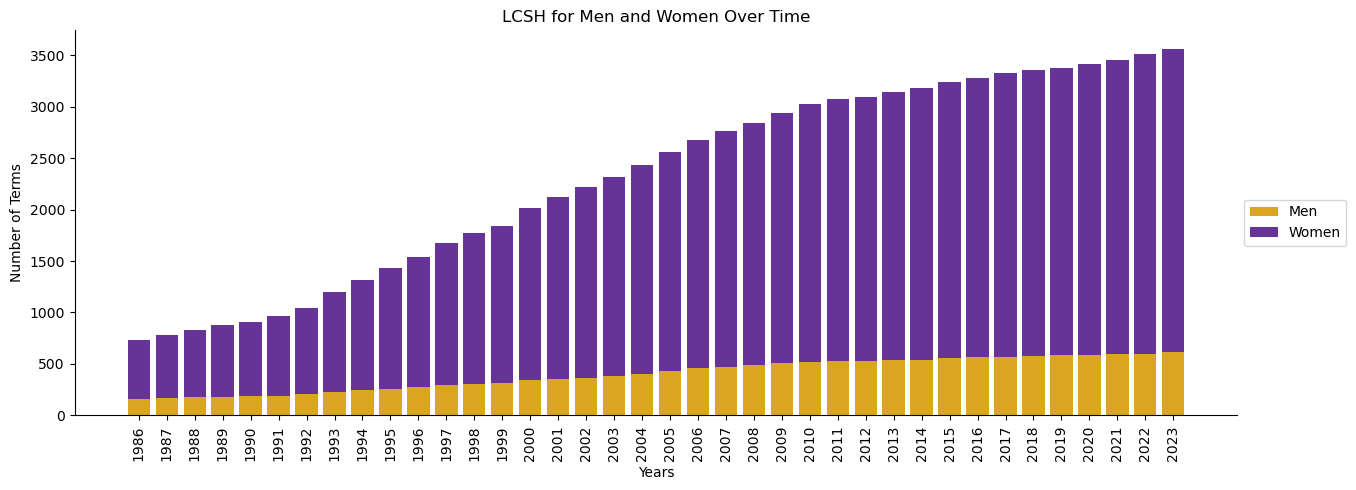

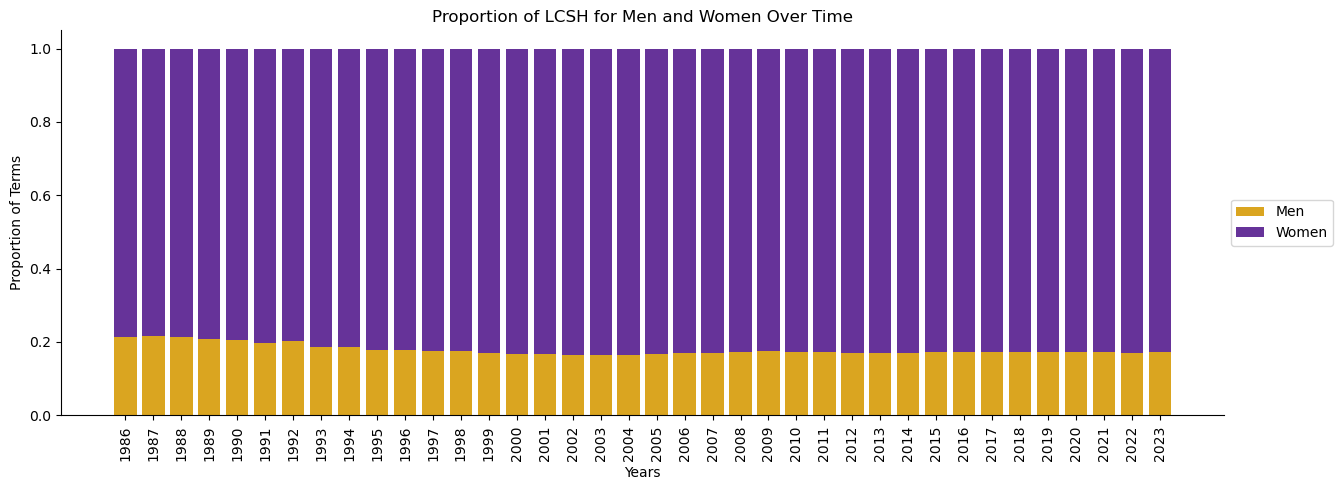

In [39]:
timelineW = getTimeLine(wTerms)
timelineM = getTimeLine(mTerms)

culmW = np.cumsum(list(timelineW.values()))
culmM = np.cumsum(list(timelineM.values()))
yData = {
    "Men": culmM,
    "Women": culmW,
}
x = list(timelineM.keys())

colours = ['goldenrod', 'rebeccapurple']
plotStacked(x, yData, colours, 'LCSH for Men and Women Over Time', 'Years', 'Number of Terms')



total = [culmW[i]+culmM[i] for i in range(len(culmM))]
propW = [culmW[i]/total[i] for i in range(len(culmW))]
propM = [culmM[i]/total[i] for i in range(len(culmM))]
yData = {
    "Men": propM,
    "Women": propW,
}
plotStacked(x, yData, colours, 'Proportion of LCSH for Men and Women Over Time', 'Years', 'Proportion of Terms')

### Average Term Length

I thought that women might have a higher n-gram length on average, however that wasn't the case. 

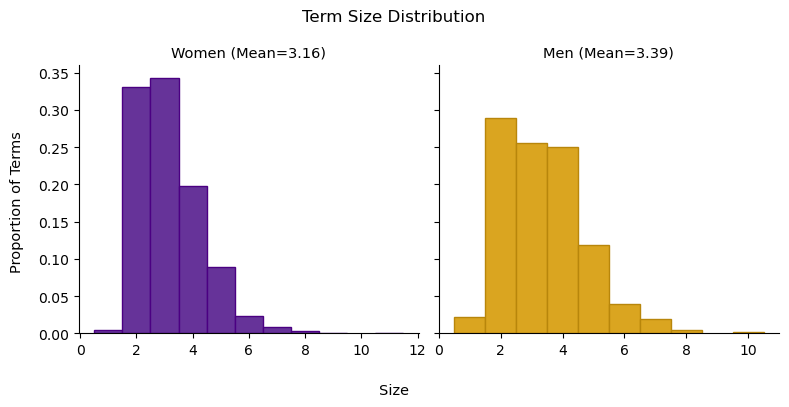

In [68]:
sizeW = sorted([len(term['heading'].replace('-', ' ').split(' ')) for term in wTerms.values()])
sizeM = sorted([len(term['heading'].replace('-', ' ').split(' ')) for term in mTerms.values()])

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
distW = {num: count/len(sizeW) for num, count in dict(collections.Counter(sizeW)).items()}
distM = {num: count/len(sizeM) for num, count in dict(collections.Counter(sizeM)).items()}
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)
axs[0].bar(*zip(*distW.items()), 1, color='rebeccapurple', edgecolor='indigo')
axs[1].bar(*zip(*distM.items()), 1, color='goldenrod', edgecolor='darkgoldenrod')
fig.supylabel('Proportion of Terms', fontsize=10.5)
fig.supxlabel('Size', fontsize=10.5)
fig.suptitle('Term Size Distribution', fontsize=12)
axs[0].set_title(f'Women (Mean={np.mean(sizeW):.2f})', fontsize=10.5)
axs[1].set_title(f'Men (Mean={np.mean(sizeM):.2f})', fontsize=10.5)
plt.show()

### Library of Congress Category Breakdown of Terms

There are 337 (11.35%) terms for Women with an associated category and 135 (22.02%) for Men.


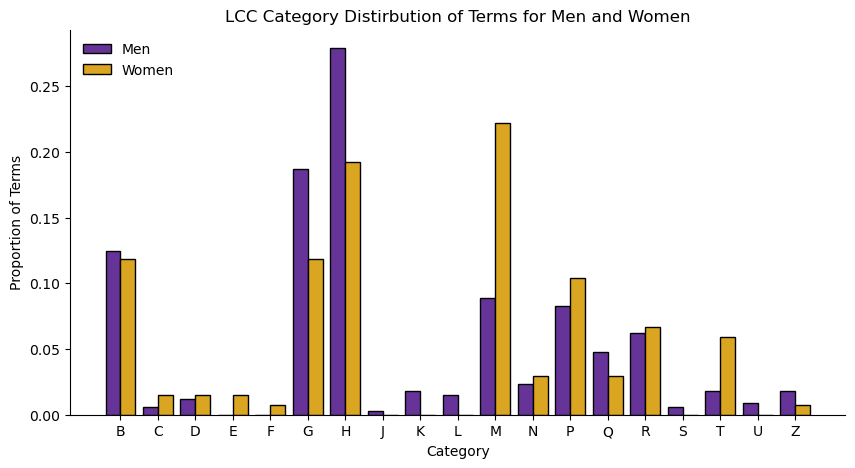

In [69]:
wLCCTerms = getLCCTerms(wTerms)
mLCCTerms = getLCCTerms(mTerms)

print(f'There are {len(wLCCTerms):,} ({percent(len(wLCCTerms), len(wTerms)):.2f}%) terms for Women with an associated category and {len(mLCCTerms):,} ({percent(len(mLCCTerms), len(mTerms)):.2f}%) for Men.')

wCats = getCatBreakdown(wLCCTerms)
mCats = getCatBreakdown(mLCCTerms)

compareLCC(wCats, mCats, 'Terms')

## Ngram Analysis

I use [Google Ngrams](https://books.google.com/ngrams/info) to appoximate the frequency of LCSHs in books before their addition to the LCSH. 

I focus on terms added between 1990 and 2017. The lower bound is chosen so that it is easier to assume that the terms were added because they were new to the LCSH and not because they were in the process of being digitized. The upper bound so there is a guarentee that, for every term, we have ngram frequency for at least 2 years after its addition to the LCSH. 

In [70]:
mSubset = {idx:head for idx, head in mTerms.items() if getNew(head) >= 1990 and getNew(head) <=2017 and '_' not in head['heading']}
wSubset = {idx:head for idx, head in wTerms.items() if getNew(head) >= 1990 and getNew(head) <=2017 and '_' not in head['heading']}

mGrams, mYrs, mIdx = getNgrams(mSubset, 5, True)
wGrams, wYrs, wIdx = getNgrams(wSubset, 5, True)

with open('Data/Ngrams/mGrams.txt', 'w') as f:
    for i in range(len(mGrams)):
        f.write(f'{mIdx[i]}\t{mGrams[i]}\t{mYrs[i]}\n')

with open('Data/Ngrams/wGrams.txt', 'w') as f:
    for i in range(len(wGrams)):
        f.write(f'{wIdx[i]}\t{wGrams[i]}\t{wYrs[i]}\n')

print(f'There are {len(mGrams)} potential N-grams for men and {len(wGrams)} for women.')


There are 371 potential N-grams for men and 1985 for women.


### Average Probability Distribution

Looks at the proportion of counts over a 13 year span that occur in each year. The span includes that date that term was added to the LCSH, as well as 10 years before and 2 years after. 

No N-gram frequency for window at index 269
80.59% of terms for men were in google N-gram and 80.20% for women.


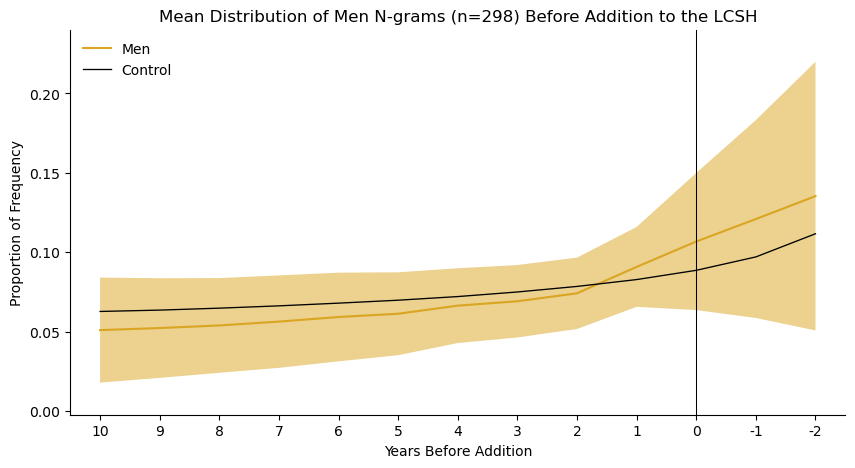

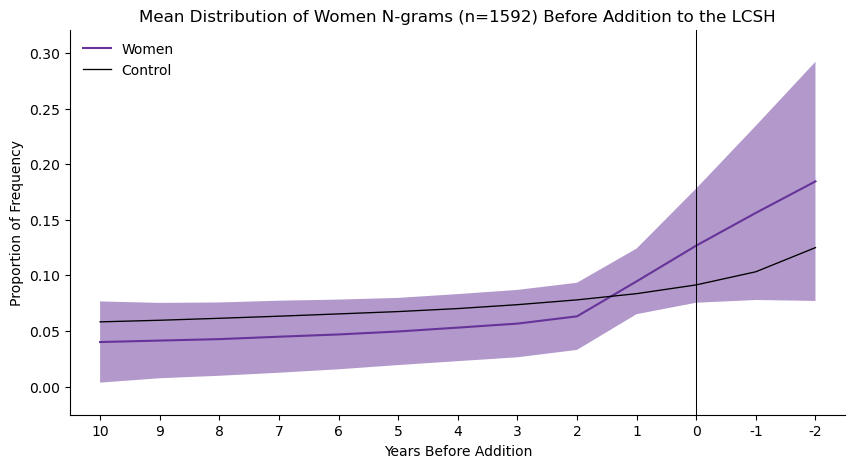

In [71]:
mFreqs, mYrs, mHeads, mIndices = getData('Data/Ngrams/mGrams.csv')
mAvg, mStd = getAvgProp(mFreqs, mYrs, 10, 2)
mControl = getControl(mFreqs, 10, 2)


wFreqs, wYrs, wHeads, wIndices = getData('Data/Ngrams/wGrams.csv')
wAvg, wStd = getAvgProp(wFreqs, wYrs, 10, 2)
wControl = getControl(wFreqs, 10, 2)

print(f'{percent(len(mHeads), len(mGrams)):.2f}% of terms for men were in google N-gram and {percent(len(wHeads), len(wGrams)):.2f}% for women.')

plotAvgFreq(mAvg, mStd, 'Men', len(mYrs)-1, color='goldenrod', control=mControl)
plotAvgFreq(wAvg, wStd, 'Women', len(wYrs), color='rebeccapurple', control=wControl)



In [72]:
print(f"The frequency for the term '{mHeads[272]}' is 0 for the window in which it was added (year={mYrs[272]}).")

The frequency for the term 'rural gay men' is 0 for the window in which it was added (year=1997).


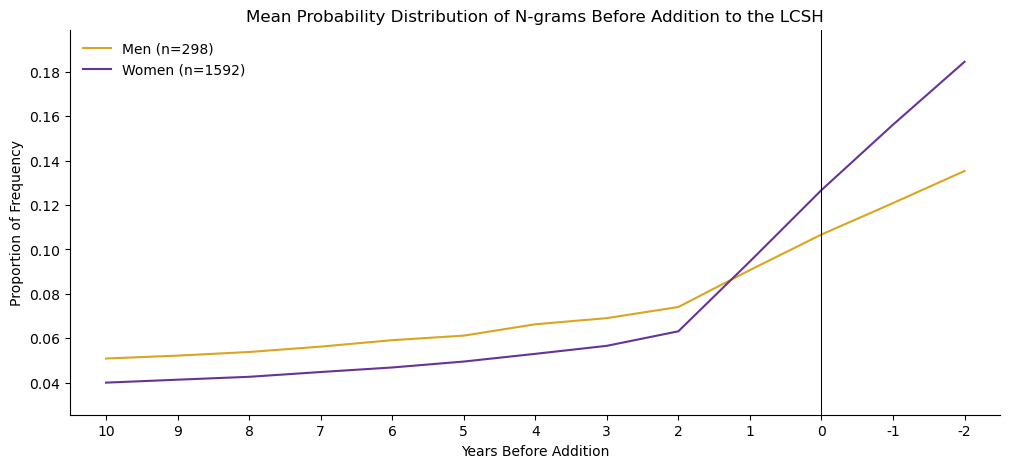

In [73]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.spines[['top', 'right']].set_visible(False)
x = [i for i in range(2, -(10+1), -1)]
x.reverse()
plt.plot(x, mAvg, label=f'Men (n={len(mYrs)-1})', color='goldenrod')

plt.plot(x, wAvg, label=f'Women (n={len(wYrs)})', color='rebeccapurple')

plt.axvline(x = 0, color = 'black', linewidth=0.75)
plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5, 2+0.5)
plt.margins(0, 0.1)
plt.title(f'Mean Probability Distribution of N-grams Before Addition to the LCSH')
plt.xlabel('Years Before Addition')
plt.ylabel('Proportion of Frequency')
plt.legend(frameon=False)
plt.show()

### Average Culmulative Frequency
Frequency was pretty skewed so I looked at boxplots for the average culmulative frequency first

No N-gram frequency for window at index 269


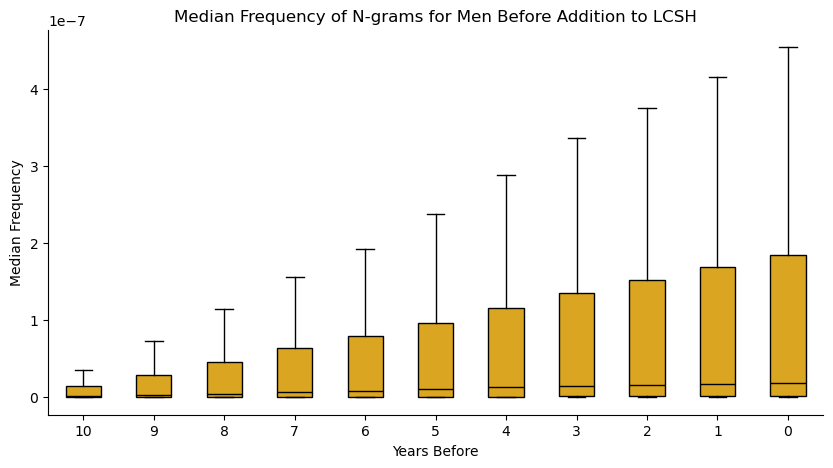

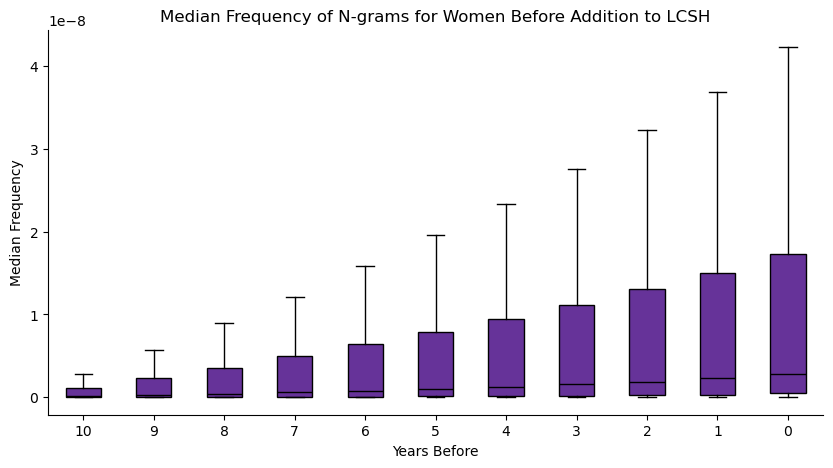

In [74]:
mCulm = getCulmFreqs(mFreqs, mYrs, 10, 0)
wCulm = getCulmFreqs(wFreqs, wYrs, 10, 0)

culmBoxPlot(mCulm, 'Men', 'goldenrod')
culmBoxPlot(wCulm, 'Women', 'rebeccapurple')

The errorbars are a bit high. Its not unexpected that the average frequency is super variable but also I don't quite know what to make of it. Also, including outliers in the plots makes everything else so small that it's difficult to interpret. I just plotted the medians as barplots on their own as well. 

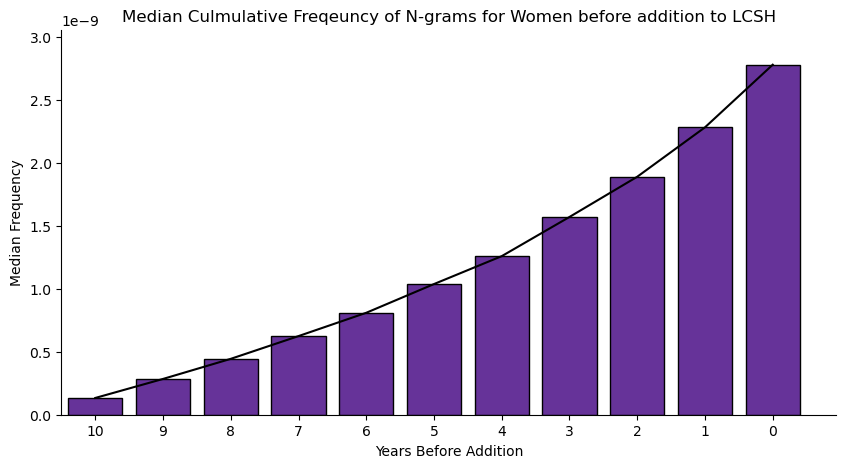

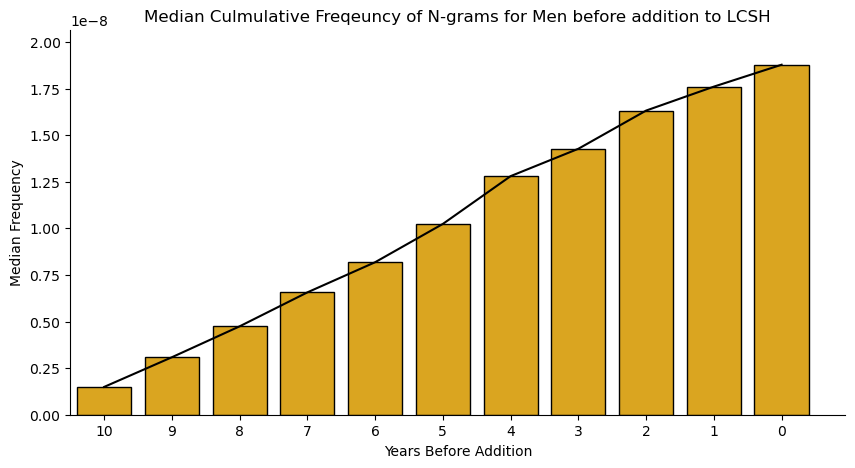

In [75]:
wCulmAvg = np.median(wCulm, axis=0)
mCulmAvg = np.median(mCulm, axis=0)
barPlots(wCulmAvg, 10, 0, 'Women', 'rebeccapurple')
barPlots(mCulmAvg, 10, 0, 'Men', 'goldenrod')

Overall the average for men is much higher than for women but the increase for women is relatively steeper than it is for men. (The higher frequency of terms for men really went against my intuition of what the results would be)

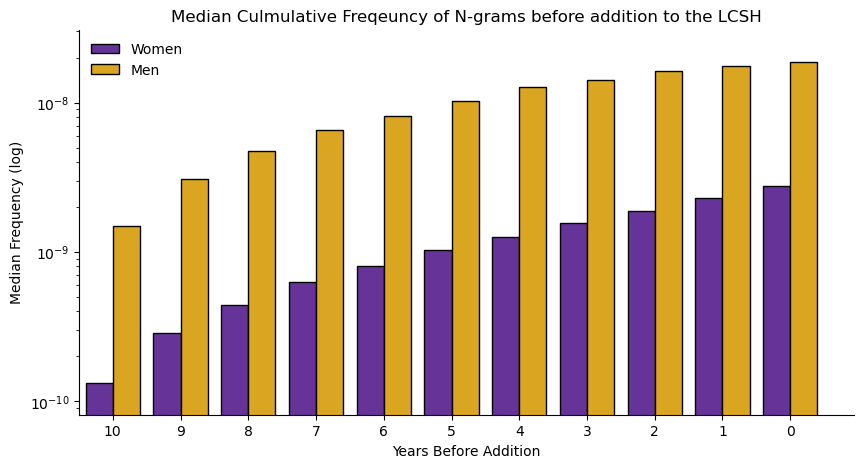

In [76]:
# Average culmulative frequency before addition to the LCSH
width = 0.4
x = [i for i in range(0, -(10+1), -1)]
x.reverse()
x = np.array(x)
_, ax = plt.subplots(figsize = (10, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.bar(x-width,wCulmAvg, width, color='rebeccapurple',label='Women',align='edge', edgecolor='black')
ax.bar(x,mCulmAvg, width, color='goldenrod',label='Men',align='edge', edgecolor='black')

plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5)
plt.margins(0, 0.1)
plt.title(f'Median Culmulative Freqeuncy of N-grams before addition to the LCSH')
plt.xlabel('Years Before Addition')
plt.ylabel('Median Frequency (log)')
plt.legend(loc='upper left', frameon=False)
plt.yscale('log')
plt.show()

### Average size of N-grams
Again I suspected that women had a higher n-gram length on average (which could lead to terms with lower frequency), however that wasn't the case. 

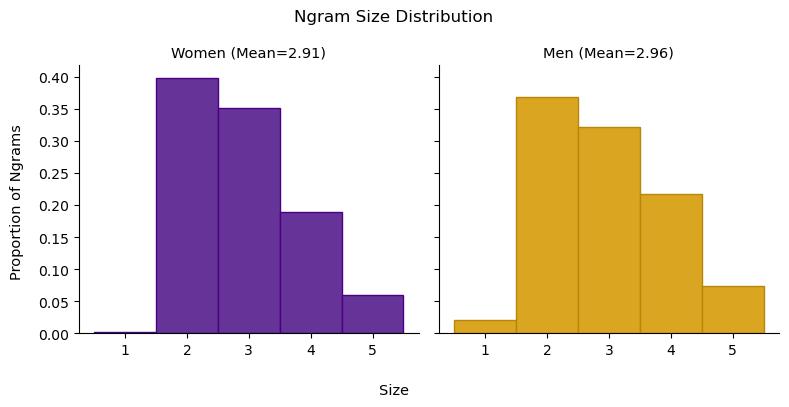

In [77]:
sizeW = sorted([len(gram.split(' ')) for gram in wHeads])
sizeM = sorted([len(gram.split(' ')) for gram in mHeads])

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
distW = {num: count/len(sizeW) for num, count in dict(collections.Counter(sizeW)).items()}
distM = {num: count/len(sizeM) for num, count in dict(collections.Counter(sizeM)).items()}
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)
axs[0].bar(*zip(*distW.items()), 1, color='rebeccapurple', edgecolor='indigo')
axs[1].bar(*zip(*distM.items()), 1, color='goldenrod', edgecolor='darkgoldenrod')
fig.supylabel('Proportion of Ngrams', fontsize=10.5)
fig.supxlabel('Size', fontsize=10.5)
fig.suptitle('Ngram Size Distribution', fontsize=12)
axs[0].set_title(f'Women (Mean={np.mean(sizeW):.2f})', fontsize=10.5)
axs[1].set_title(f'Men (Mean={np.mean(sizeM):.2f})', fontsize=10.5)
plt.show()


Would it make sense to divide these analyses by n-gram size??

### LCC Category Breakdown of Ngrams

There are 114 (7.16%) terms for Women with an associated category and 31 (10.37%) for Men.


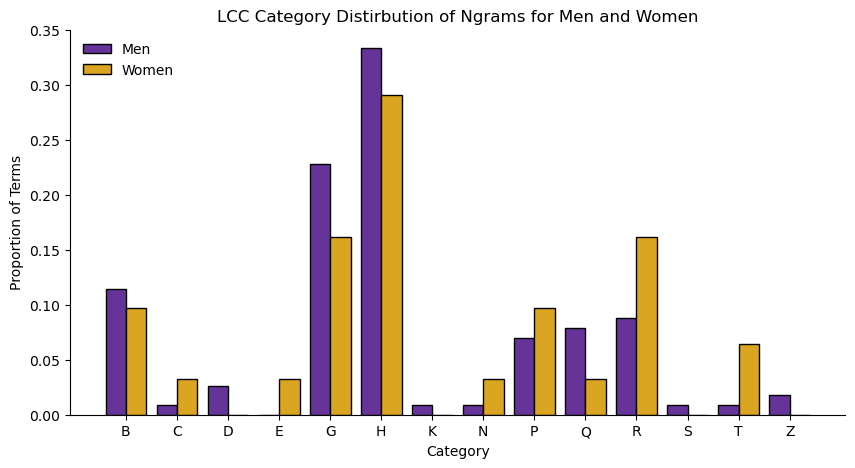

In [78]:
wLCCGrams = getLCCTerms({idx:lcsh[idx] for idx in wIndices})
mLCCGrams = getLCCTerms({idx:lcsh[idx] for idx in mIndices})

print(f'There are {len(wLCCGrams):,} ({percent(len(wLCCGrams), len(wIndices)):.2f}%) terms for Women with an associated category and {len(mLCCGrams):,} ({percent(len(mLCCGrams), len(mIndices)):.2f}%) for Men.')

wCats = getCatBreakdown(wLCCGrams)
mCats = getCatBreakdown(mLCCGrams)

compareLCC(wCats, mCats, 'Ngrams')

#### Comparison to others sets of LCSHs
I compare the gendered LCSHS to LCSHs that correspond to the categories T (Technology), BF (Psychology), and H (Social Sciences). I focus on comparing the average probability distributions as opposed to the average culmulative frequencies. There is some overlap betweem the gendered terms and the other sets of LCSH. 

In [79]:
# techTerms = {idx:head for idx, head in lccTerms.items() if (head['lcc'][0].upper() == 'T'
#                                                             and head['type'] == 'Topic'
#                                                             and head['lang'] == 'en'
#                                                             and getNew(head) >= 1990
#                                                             and getNew(head) <=2017
#                                                             and head['heading'][0] != '_')}
# techGrams, techYrs, techIdx = getNgrams(techTerms, 5)
# with open('Data/Ngrams/techGrams.txt', 'w') as f:
#     for i in range(len(techGrams)):
#         f.write(f'{techIdx[i]}\t{techGrams[i]}\t{techYrs[i]}\n')


# socTerms = {idx:head for idx, head in lccTerms.items()  if (head['lcc'][0].upper() == 'H'
#                                                             and head['type'] == 'Topic'
#                                                             and head['lang'] == 'en'
#                                                             and getNew(head) >= 1990
#                                                             and getNew(head) <=2017
#                                                             and head['heading'][0] != '_')}
# socGrams, socYrs, socIdx = getNgrams(socTerms, 5)
# with open('Data/Ngrams/socGrams.txt', 'w') as f:
#     for i in range(len(socGrams)):
#         f.write(f'{socIdx[i]}\t{socGrams[i]}\t{socYrs[i]}\n')

# psychTerms = {idx:head for idx, head in lccTerms.items()  if (head['lcc'][:2].upper() == 'BF'
#                                                             and head['type'] == 'Topic'
#                                                             and head['lang'] == 'en'
#                                                             and getNew(head) >= 1990
#                                                             and getNew(head) <=2017
#                                                             and head['heading'][0] != '_')}
# psychGrams, psychYrs, psychIdx = getNgrams(psychTerms, 5)
# with open('Data/Ngrams/psychGrams.txt', 'w') as f:
#     for i in range(len(psychGrams)):
#         f.write(f'{psychIdx[i]}\t{psychGrams[i]}\t{psychYrs[i]}\n')

In [80]:
techFreqs, techYrs, _, _ = getData('Data/Ngrams/techGrams.csv')
techAvg, _ = getAvgProp(techFreqs, techYrs, 10, 2)

socFreqs, socYrs, _, _ = getData('Data/Ngrams/socGrams.csv')
socAvg, _ = getAvgProp(socFreqs, socYrs, 10, 2)

psychFreqs, psychYrs, _, _ = getData('Data/Ngrams/psychGrams.csv')
psychAvg, _ = getAvgProp(psychFreqs, psychYrs, 10, 2)

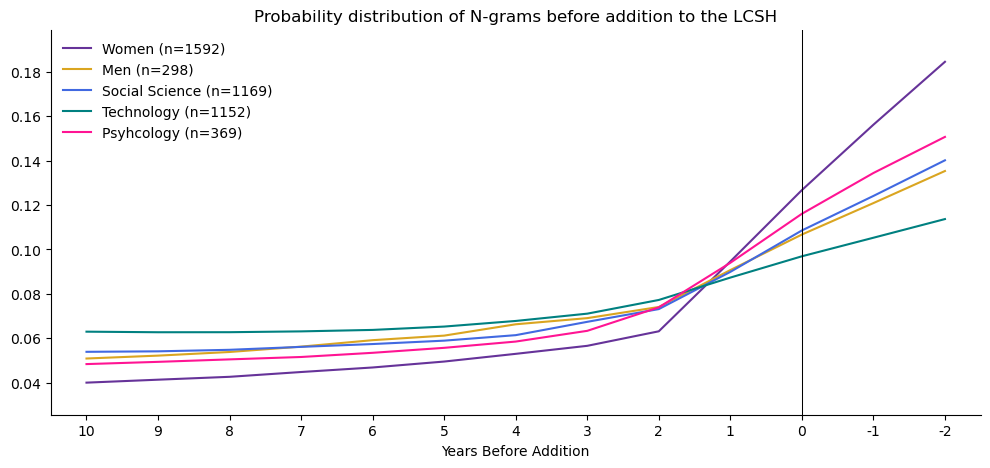

In [81]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.spines[['top', 'right']].set_visible(False)
x = [i for i in range(2, -(10+1), -1)]
x.reverse()
plt.plot(x, wAvg, label=f'Women (n={len(wYrs)})', color='rebeccapurple')
plt.plot(x, mAvg, label=f'Men (n={len(mYrs)-1})', color='goldenrod')
plt.plot(x, socAvg, label=f'Social Science (n={len(socYrs)})', color='royalblue')
plt.plot(x, techAvg, label=f'Technology (n={len(techYrs)})', color='teal')
plt.plot(x, psychAvg, label=f'Psyhcology (n={len(psychYrs)})', color='deeppink')

plt.axvline(x = 0, color = 'black', linewidth=0.75)
plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5, 2+0.5)
plt.margins(0, 0.1)
plt.title(f'Probability distribution of N-grams before addition to the LCSH')
plt.xlabel('Years Before Addition')
plt.legend(frameon=False)
plt.show()

Women seem to hava a much more identifiable point of inflection at the 2 year mark (even though the other categories have some overlap with the women and men terms).

### Paired Terms

In [82]:
pairs = []
with open('Data/pairedTerms.txt', 'r') as f:
    for line in f:
        pair = line.replace('\n', '').split('\t')
        pairs.append(pair)
pairedTerms = findPairs(mTerms, wTerms, pairs)

with open('Data/LCSH/pairs-lcsh.txt', 'w') as f:
    for mTerm, wTerm in pairedTerms:
        f.write(f'{mTerm[1]['heading']}\t{wTerm[1]['heading']}\n')

print(f'There are {len(pairedTerms)} paired terms in the LCSH.')

There are 336 paired terms in the LCSH.


#### Category Breakdown

There are 88 (26.19%) paired terms for Women with an associated category and 69 (20.54%) for Men.


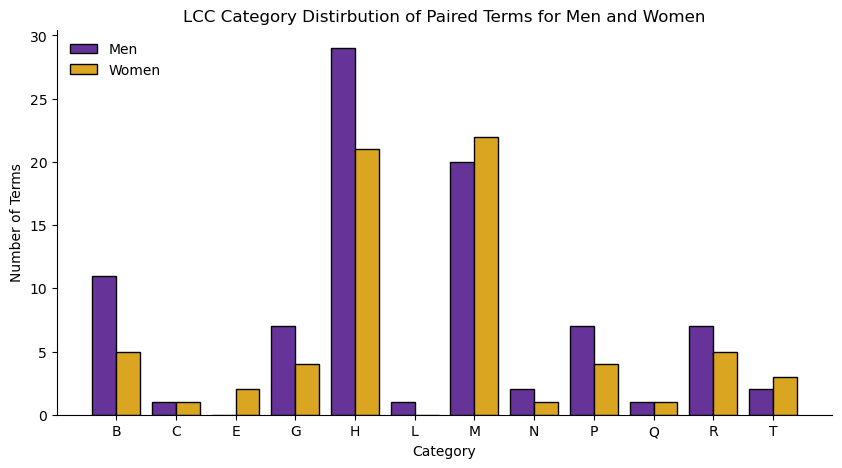

In [98]:
w = [w[0] for _,w in pairedTerms]
m = [m[0] for m,_ in pairedTerms]

wPairedLCC = getLCCTerms({idx:lcsh[idx] for idx in w})
mPairedLCC = getLCCTerms({idx:lcsh[idx] for idx in m})

print(f'There are {len(wPairedLCC):,} ({percent(len(wPairedLCC), len(pairedTerms)):.2f}%) paired terms for Women with an associated category and {len(mPairedLCC):,} ({percent(len(mPairedLCC), len(pairedTerms)):.2f}%) for Men.')

wCats = getCatBreakdown(wPairedLCC, raw=True) 
mCats = getCatBreakdown(mPairedLCC, raw=True)

compareLCC(wCats, mCats, 'Paired Terms', raw=True)

In [84]:
justWomen = [w[1]['heading'] for m, w in pairedTerms if w[0] in wPairedLCC.keys() and m[0] not in mPairedLCC.keys()]
justMen = [m[1]['heading'] for m, w in pairedTerms if w[0] not in wPairedLCC.keys() and m[0] in mPairedLCC.keys()]

print(f'There are {len(justWomen)} paired terms were only the terms for women have a LCC:')
for i in range(0, len(justWomen)-1, 2):
    print(f'\t"{justWomen[i]}", "{justWomen[i+1]}",')

print(f'\nThere are {len(justMen)} paired terms were only the terms for men have a LCC:')
for i in range(0, len(justMen)-1, 2):
    print(f'\t"{justMen[i]}", "{justMen[i+1]}",')
print(f'\t"{justMen[-1]}')

There are 36 paired terms were only the terms for women have a LCC:
	"Women with mental disabilities", "Women in church work",
	"Women in the Bible", "Women on television",
	"Women's health services", "Women's dreams",
	"Working class women", "Muslim women",
	"Preaching to women", "Church work with women",
	"Single women", "Skiing for women",
	"Jewish women", "Psychologically abused women",
	"Women prisoners", "Women teachers",
	"Women murderers", "Women employees",
	"Girls in motion pictures", "Sexually abused girls",
	"Gymnastics for girls", "Teenage girls",
	"Middle-aged mothers", "Mothers on television",
	"Stay-at-home mothers", "Mothers of children with disabilities",
	"Mothers in motion pictures", "Mothers in art",
	"Teenage mothers", "Absentee mothers",
	"Aunts", "Brides",
	"Older lesbians", "Abused lesbians",
	"Lesbians' writings, Canadian", "Lesbians' writings, American",

There are 17 paired terms were only the terms for men have a LCC:
	"Men in motion pictures", "Choruses, S

The focus will be on pairs of terms where at least one was added in 1990 or later

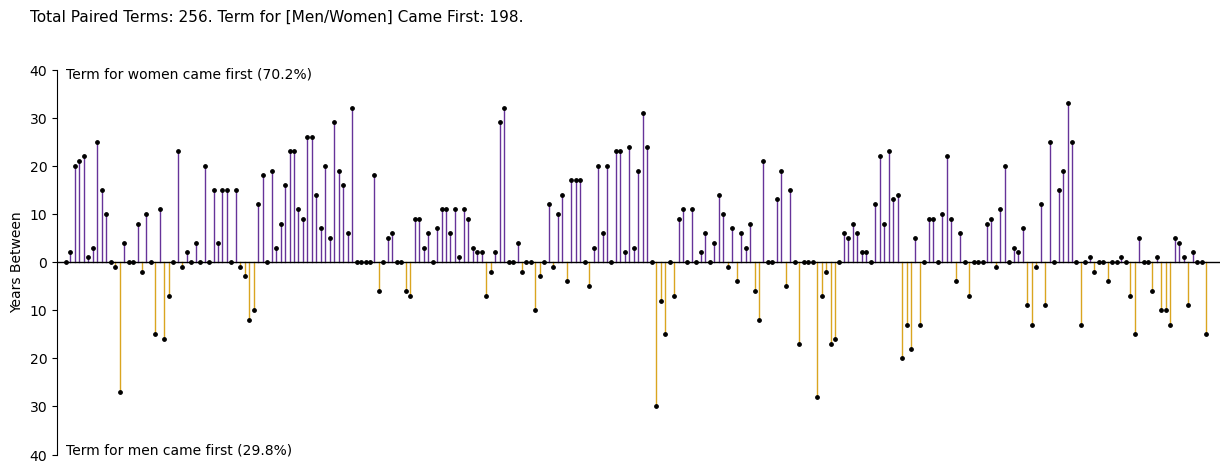

In [85]:
y = [getNew(m[1]) - getNew(w[1]) for m,w in pairedTerms if getNew(m[1]) >= 1990 or getNew(w[1]) >= 1990]
x = [i for i in range(len(y))]
base = [0 for _ in range(len(y))]
fig, ax = plt.subplots(figsize = (15, 5))
ax.spines[['bottom', 'top', 'right']].set_visible(False)
firstF, firstM = 0, 0
for i in range(len(y)):
    if y[i] < 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="goldenrod", linewidth=1, zorder=-1)
        firstM += 1
    if y[i] > 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="rebeccapurple", linewidth=1, zorder=-1)
        firstF += 1
plt.text(0, 39, f'Term for women came first ({(firstF/(firstF + firstM))*100:.1f}%)', verticalalignment='center')
plt.text(0, -39, f'Term for men came first ({firstM/(firstF + firstM)*100:.1f}%)', verticalalignment='center')

plt.plot([-2] + x + [len(x)+2], [0] + base + [0], color='black', linewidth=1)
plt.scatter(x, y, c='black', marker='o', s=6, zorder=1)
plt.margins(0)
plt.axis([-2, len(x)+2, -40, 40])
plt.yticks([i for i in range(-40, 41, 10)], [abs(i) for i in range(-40, 41, 10)])
plt.ylabel('Years Between')
plt.xticks([])
plt.text(-8, 50, f'Total Paired Terms: {len(y)}. Term for [Men/Women] Came First: {firstF+firstM}.', fontsize=11)
plt.show()

#### Ngram Subset of Paired Terms

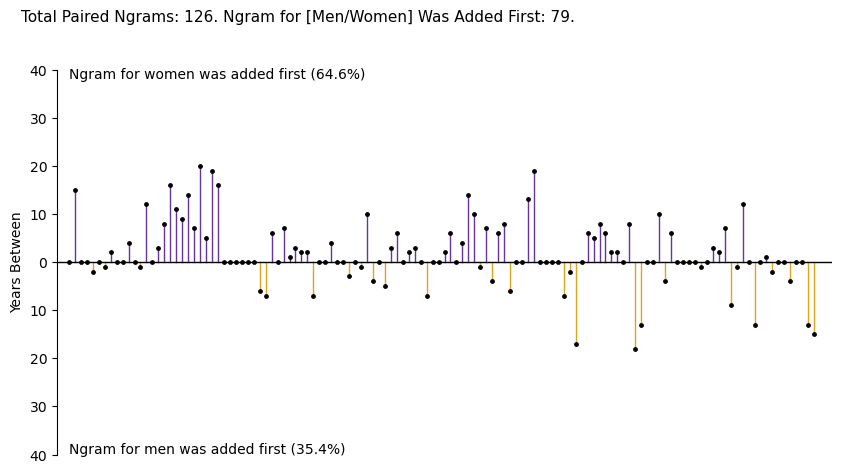

In [86]:
pairedGrams = [(lcsh[m[0]], lcsh[w[0]]) for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices]

y = [getNew(m) - getNew(w) for m,w in pairedGrams]
x = [i for i in range(len(y))]
base = [0 for _ in range(len(y))]
fig, ax = plt.subplots(figsize = (10, 5))
ax.spines[['bottom', 'top', 'right']].set_visible(False)
firstF, firstM = 0, 0
for i in range(len(y)):
    if y[i] < 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="goldenrod", linewidth=1, zorder=-1)
        firstM += 1
    if y[i] > 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="rebeccapurple", linewidth=1, zorder=-1)
        firstF += 1
plt.text(0, 39, f'Ngram for women was added first ({(firstF/(firstF + firstM))*100:.1f}%)', verticalalignment='center')
plt.text(0, -39, f'Ngram for men was added first ({firstM/(firstF + firstM)*100:.1f}%)', verticalalignment='center')

plt.plot([-2] + x + [len(x)+2], [0] + base + [0], color='black', linewidth=1)
plt.scatter(x, y, c='black', marker='o', s=6, zorder=1)
plt.margins(0)
plt.axis([-2, len(x)+2, -40, 40])
plt.yticks([i for i in range(-40, 41, 10)], [abs(i) for i in range(-40, 41, 10)])
plt.ylabel('Years Between')
plt.xticks([])
plt.text(-8, 50, f'Total Paired Ngrams: {len(y)}. Ngram for [Men/Women] Was Added First: {firstF+firstM}.', fontsize=11)
plt.show()

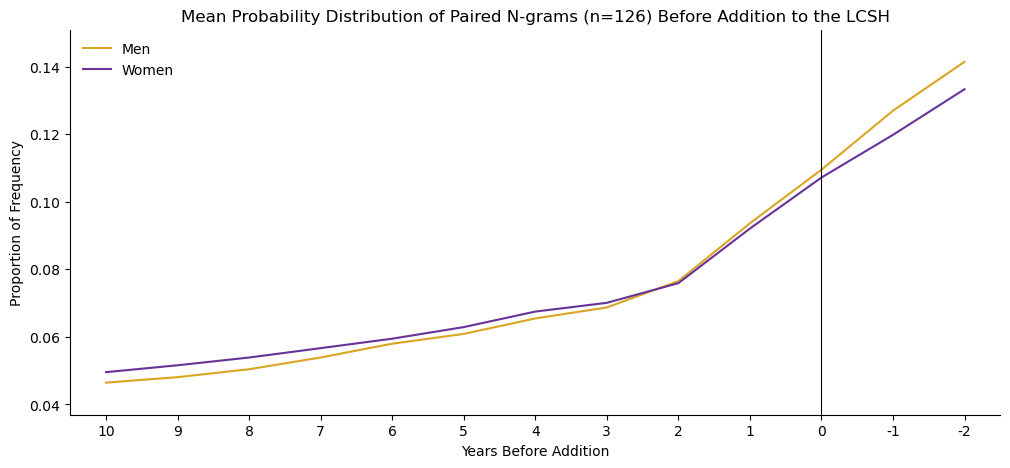

In [87]:
w = [w[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices]
wPairIdx = [i for i in range(len(wIndices)) if wIndices[i] in w]
wPairedFreqs = wFreqs[wPairIdx]
wPairedYrs = np.array(wYrs)[wPairIdx]
wAvg, wStd = getAvgProp(wPairedFreqs, wPairedYrs, 10, 2)

m = [m[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices]
mPairIdx = [i for i in range(len(mIndices)) if mIndices[i] in m]
mPairedFreqs = mFreqs[mPairIdx]
mPairedYrs = np.array(mYrs)[mPairIdx]
mAvg, mStd = getAvgProp(mPairedFreqs, mPairedYrs, 10, 2)

fig, ax = plt.subplots(figsize = (12, 5))
ax.spines[['top', 'right']].set_visible(False)
x = [i for i in range(2, -(10+1), -1)]
x.reverse()
plt.plot(x, mAvg, label=f'Men', color='goldenrod')

plt.plot(x, wAvg, label=f'Women', color='rebeccapurple')

plt.axvline(x = 0, color = 'black', linewidth=0.75)
plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5, 2+0.5)
plt.margins(0, 0.1)
plt.title(f'Mean Probability Distribution of Paired N-grams (n={mPairedYrs.shape[0]}) Before Addition to the LCSH')
plt.xlabel('Years Before Addition')
plt.ylabel('Proportion of Frequency')
plt.legend(frameon=False, loc='upper left')
plt.show()


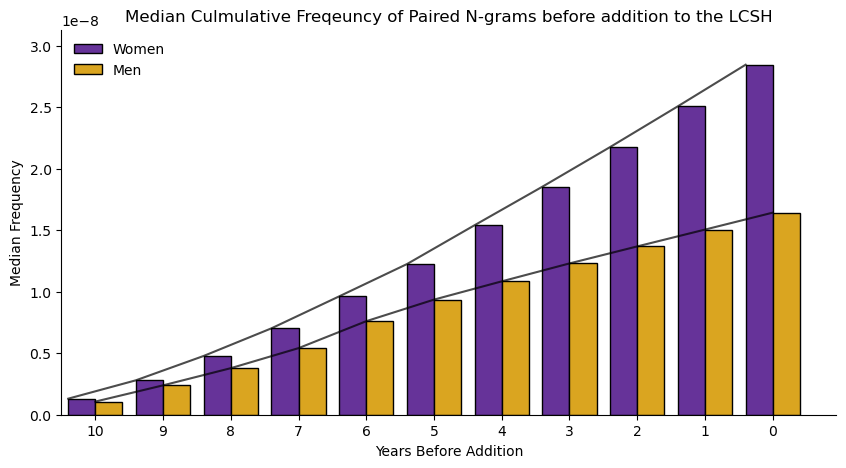

In [88]:
mCulmPair = getCulmFreqs(mPairedFreqs, mPairedYrs, 10, 0)
wCulmPair = getCulmFreqs(wPairedFreqs, wPairedYrs, 10, 0)

wCulmAvgPair = np.median(wCulmPair, axis=0)
mCulmAvgPair = np.median(mCulmPair, axis=0)

width = 0.4
x = [i for i in range(0, -(10+1), -1)]
x.reverse()
x = np.array(x)
_, ax = plt.subplots(figsize = (10, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.bar(x-width,wCulmAvgPair, width, color='rebeccapurple',label='Women',align='edge', edgecolor='black')
ax.plot(x-width, wCulmAvgPair, color='black', alpha=0.7)
ax.bar(x,mCulmAvgPair, width, color='goldenrod',label='Men',align='edge', edgecolor='black')
ax.plot(x, mCulmAvgPair, color='black', alpha=0.7)

plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5)
plt.margins(0, 0.1)
plt.title(f'Median Culmulative Freqeuncy of Paired N-grams before addition to the LCSH')
plt.xlabel('Years Before Addition')
plt.ylabel('Median Frequency')
plt.legend(loc='upper left', frameon=False)
plt.show()

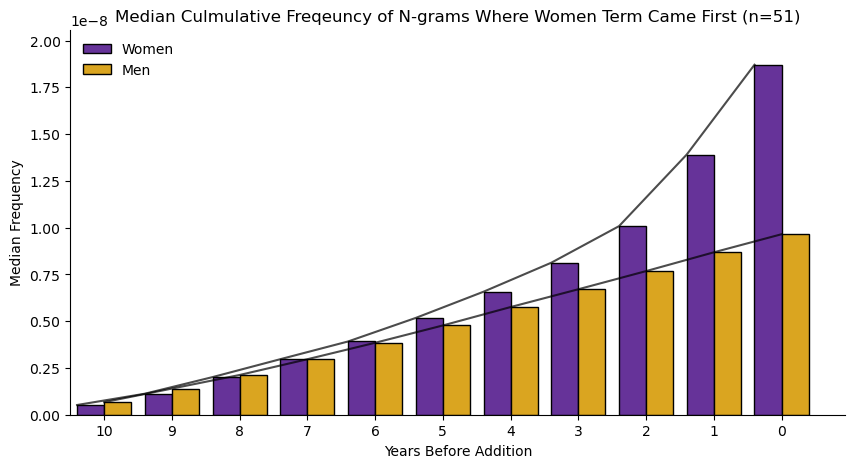

In [89]:
w = [w[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) < getNew(m[1])]
wPairIdx = [i for i in range(len(wIndices)) if wIndices[i] in w]
wPairedFreqs = wFreqs[wPairIdx]
wPairedYrs = np.array(wYrs)[wPairIdx]

m = [m[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) < getNew(m[1])]
mPairIdx = [i for i in range(len(mIndices)) if mIndices[i] in m]
mPairedFreqs = mFreqs[mPairIdx]
mPairedYrs = np.array(mYrs)[mPairIdx]

mCulmPair = getCulmFreqs(mPairedFreqs, mPairedYrs, 10, 0)
wCulmPair = getCulmFreqs(wPairedFreqs, wPairedYrs, 10, 0)
wCulmAvgPair = np.median(wCulmPair, axis=0)
mCulmAvgPair = np.median(mCulmPair, axis=0)

width = 0.4
x = [i for i in range(0, -(10+1), -1)]
x.reverse()
x = np.array(x)
_, ax = plt.subplots(figsize = (10, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.bar(x-width,wCulmAvgPair, width, color='rebeccapurple',label='Women',align='edge', edgecolor='black')
ax.plot(x-width, wCulmAvgPair, color='black', alpha=0.7)
ax.bar(x,mCulmAvgPair, width, color='goldenrod',label='Men',align='edge', edgecolor='black')
ax.plot(x, mCulmAvgPair, color='black', alpha=0.7)

plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5)
plt.margins(0, 0.1)
plt.title(f'Median Culmulative Freqeuncy of N-grams Where Women Term Came First (n={len(w)})')
plt.xlabel('Years Before Addition')
plt.ylabel('Median Frequency')
plt.legend(loc='upper left', frameon=False)
plt.show()


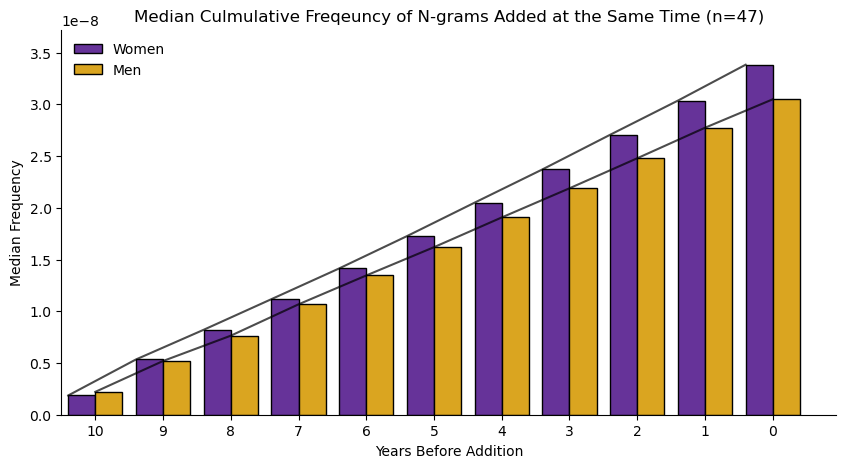

In [90]:
w = [w[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) ==  getNew(m[1])]
wPairIdx = [i for i in range(len(wIndices)) if wIndices[i] in w]
wPairedFreqs = wFreqs[wPairIdx]
wPairedYrs = np.array(wYrs)[wPairIdx]

m = [m[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) == getNew(m[1])]
mPairIdx = [i for i in range(len(mIndices)) if mIndices[i] in m]
mPairedFreqs = mFreqs[mPairIdx]
mPairedYrs = np.array(mYrs)[mPairIdx]

mCulmPair = getCulmFreqs(mPairedFreqs, mPairedYrs, 10, 0)
wCulmPair = getCulmFreqs(wPairedFreqs, wPairedYrs, 10, 0)
wCulmAvgPair = np.median(wCulmPair, axis=0)
mCulmAvgPair = np.median(mCulmPair, axis=0)

width = 0.4
x = [i for i in range(0, -(10+1), -1)]
x.reverse()
x = np.array(x)
_, ax = plt.subplots(figsize = (10, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.bar(x-width,wCulmAvgPair, width, color='rebeccapurple',label='Women',align='edge', edgecolor='black')
ax.plot(x-width, wCulmAvgPair, color='black', alpha=0.7)
ax.bar(x,mCulmAvgPair, width, color='goldenrod',label='Men',align='edge', edgecolor='black')
ax.plot(x, mCulmAvgPair, color='black', alpha=0.7)

plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5)
plt.margins(0, 0.1)
plt.title(f'Median Culmulative Freqeuncy of N-grams Added at the Same Time (n={len(w)})')
plt.xlabel('Years Before Addition')
plt.ylabel('Median Frequency')
plt.legend(loc='upper left', frameon=False)
plt.show()



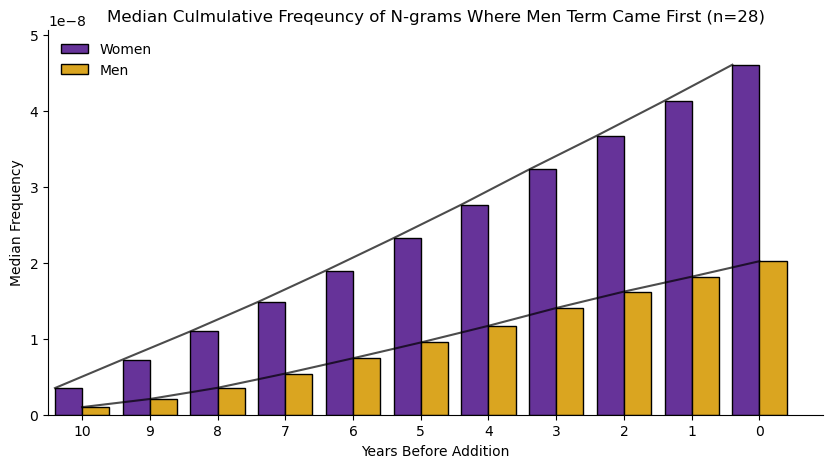

In [91]:
w = [w[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) > getNew(m[1])]
wPairIdx = [i for i in range(len(wIndices)) if wIndices[i] in w]
wPairedFreqs = wFreqs[wPairIdx]
wPairedYrs = np.array(wYrs)[wPairIdx]

m = [m[0] for m, w in pairedTerms if w[0] in wIndices and m[0] in mIndices and getNew(w[1]) > getNew(m[1])]
mPairIdx = [i for i in range(len(mIndices)) if mIndices[i] in m]
mPairedFreqs = mFreqs[mPairIdx]
mPairedYrs = np.array(mYrs)[mPairIdx]

mCulmPair = getCulmFreqs(mPairedFreqs, mPairedYrs, 10, 0)
wCulmPair = getCulmFreqs(wPairedFreqs, wPairedYrs, 10, 0)
wCulmAvgPair = np.median(wCulmPair, axis=0)
mCulmAvgPair = np.median(mCulmPair, axis=0)

width = 0.4
x = [i for i in range(0, -(10+1), -1)]
x.reverse()
x = np.array(x)
_, ax = plt.subplots(figsize = (10, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.bar(x-width,wCulmAvgPair, width, color='rebeccapurple',label='Women',align='edge', edgecolor='black')
ax.plot(x-width, wCulmAvgPair, color='black', alpha=0.7)
ax.bar(x,mCulmAvgPair, width, color='goldenrod',label='Men',align='edge', edgecolor='black')
ax.plot(x, mCulmAvgPair, color='black', alpha=0.7)

plt.xticks([x[i] for i in range(0, len(x))], [-(x[i]) for i in range(0, len(x))])
plt.xlim(-10-0.5)
plt.margins(0, 0.1)
plt.title(f'Median Culmulative Freqeuncy of N-grams Where Men Term Came First (n={len(m)})')
plt.xlabel('Years Before Addition')
plt.ylabel('Median Frequency')
plt.legend(loc='upper left', frameon=False)
plt.show()

## Un-paired Terms

In [92]:
wPairIdx = [w[0] for _, w in pairedTerms]
mPairIdx = [m[0] for m, _ in pairedTerms]


unPairedW = [term for idx, term in wTerms.items() if idx not in wPairIdx]
unPairedM = [term for idx, term in mTerms.items() if idx not in mPairIdx]

print(f'There are {len(unPairedW):,} unpaired terms for women and {len(unPairedM):,} for men.')


There are 2,632 unpaired terms for women and 277 for men.
